## Introduction to the Project
This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Read on or watch the video below to explore more details. Once you’re ready to start competing, click on the "Join Competition button to create an account and gain access to the competition data. Then check out Alexis Cook’s Titanic Tutorial that walks you through step by step how to make your first submission!

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### What Data Will I Use in This Competition?
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.


### Refrences You Might Wanna Have a Look at
Source: [Kaggle](https://www.kaggle.com/competitions/titanic)


Planning Notebook: [Planning.ipynb](https://github.com/muhammadanas0716/Machine-Learning-Projects-101/blob/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/Planning....ipynb)

In [1]:
# Importing all the needed libraries

# Remove Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Analysis and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Some Extras
import xgboost as xgb

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

Done Importing!

## Exploratory Data Analysis (EDA)
0. Most Correlated values
1. Value counts of the numeric columns
2. Frequencies Plotting (PLOTTING OF ABOVE POINT)
3. This FEATURE VS this FEATURE
4. Any Null values

### TODOS
* Removing the pre-built index column (PANDAS)
* Creating a **Family** column, by adding the **SibSp** and **Parch**
* Cnverting the **Fare** column to an integer or round the price to `1 decimal place`

In [2]:
# Loading the data
titanic_df = pd.read_csv("train.csv", index_col=0)
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


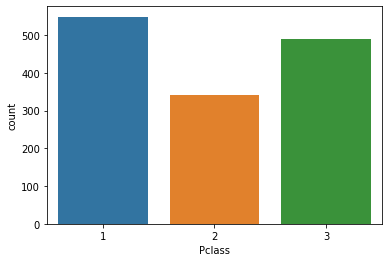

In [3]:
cols = ["Survived", "Pclass"]
for i in cols: 
    sns.countplot(data = titanic_df, x=i)

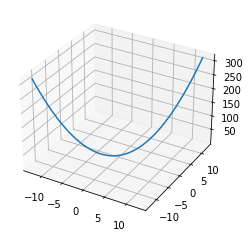

In [6]:
import numpy as np

x = np.linspace(-4*np.pi,4*np.pi,50)

y = np.linspace(-4*np.pi,4*np.pi,50)

z = x**2 + y**2

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot(x,y,z)

plt.show()